In [2]:
import os
import numpy
import polars as pl
import matplotlib.pyplot as plt
import seaborn
import glob
import pandas as pd
from typing import Dict, List


In [3]:
from os import sep

def load_files_from_directory(
    directory_path: str, 
    file_pattern: str
) -> Dict[str, pl.DataFrame]:
    """
    Loads files matching a specific pattern from a directory using Polars and stores them
    with their base file name (without extension) as the key in a dictionary.
    
    Args:
    - directory_path (str): The directory to scan for files.
    - file_pattern (str): The glob pattern to match files (e.g., '*_10000_*.phased.snpden').

    Returns:
    - Dict[str, pl.DataFrame]: A dictionary with base file names as keys and Polars DataFrames as values.
    """
    loaded_files_dict: Dict[str, pl.DataFrame] = {}
    
    # Use glob to get a list of files matching the pattern
    files: List[str] = glob.glob(os.path.join(directory_path, file_pattern))
    
    if not files:
        print(f"No files matching the pattern '{file_pattern}' were found in the directory '{directory_path}'.")
        return loaded_files_dict

    # Loop through all matching files
    for file in files:
        if os.path.isfile(file):  # Ensure it's a file
            # Extract the base file name (without path and extension)
            file_basename: str = os.path.splitext(os.path.basename(file))[0]

            try:
                # Read the CSV file into a Polars DataFrame
                df: pl.DataFrame = pl.read_csv(file, separator='\t')
                loaded_files_dict[file_basename] = df
            except Exception as e:
                print(f"Error reading {file}: {e}")
                continue
    
    return loaded_files_dict

# Example usage
file_directory: str = "../vcf_stats/"  # Specify the directory
pattern: str = "*_10000_*.phased.snpden"  # Define the file pattern

# Load files based on the pattern
files_data: Dict[str, pl.DataFrame] = load_files_from_directory(file_directory, pattern)
files_data.keys()

dict_keys(['snp_density_10000_sorted_chr_32.phased', 'snp_density_10000_sorted_chr_24.phased', 'snp_density_10000_sorted_chr_4.phased', 'snp_density_10000_sorted_chr_3.phased', 'snp_density_10000_sorted_chr_2.phased', 'snp_density_10000_sorted_chr_22.phased', 'snp_density_10000_sorted_chr_30.phased', 'snp_density_10000_sorted_chr_26.phased', 'snp_density_10000_sorted_chr_15.phased', 'snp_density_10000_sorted_chr_31.phased', 'snp_density_10000_sorted_chr_Z.phased', 'snp_density_10000_sorted_chr_27.phased', 'snp_density_10000_sorted_chr_5.phased', 'snp_density_10000_sorted_chr_25.phased', 'snp_density_10000_sorted_chr_17.phased', 'snp_density_10000_sorted_chr_14.phased', 'snp_density_10000_sorted_chr_9.phased', 'snp_density_10000_sorted_chr_10.phased', 'snp_density_10000_sorted_chr_12.phased', 'snp_density_10000_sorted_chr_16.phased', 'snp_density_10000_sorted_chr_6.phased', 'snp_density_10000_sorted_chr_20.phased', 'snp_density_10000_sorted_chr_29.phased', 'snp_density_10000_sorted_chr_

In [5]:
from email.policy import default


def merge_dataframes_from_dict(
    dataFrames: Dict[str, pl.DataFrame], 
    first_file_keyName: str
) -> pl.DataFrame:
    """
    Merges DataFrames stored in a dictionary based on a common column ('CHROM').
    Only the first DataFrame's column names will be preserved.

    Args:
    - dataframes: A dictionary where the keys are file names and the values are DataFrames.
    - first_file_keyName: The key name for the first DataFrame to use as the base for column names.

    Returns:
    - A single merged DataFrame with rows from all DataFrames, retaining the column names of the first DataFrame.
    """
    # Get the first DataFrame from the dictionary
    merged_df: pl.DataFrame = dataFrames.get(first_file_keyName, None) # type: ignore
    
    # Iterate over the rest of the DataFrames and merge them
    for key, df in dataFrames.items():
        if key != first_file_keyName:
            merged_df = merged_df.merge_sorted(df, key="CHROM", )
    
    return merged_df

merged_vcf_stats: pl.DataFrame = merge_dataframes_from_dict(files_data, 'snp_density_10000_sorted_chr_1.phased')
print(merged_vcf_stats.select("CHROM").unique().sort("CHROM"))


shape: (34, 1)
┌────────┐
│ CHROM  │
│ ---    │
│ str    │
╞════════╡
│ chr_1  │
│ chr_10 │
│ chr_11 │
│ chr_12 │
│ chr_13 │
│ …      │
│ chr_6  │
│ chr_7  │
│ chr_8  │
│ chr_9  │
│ chr_Z  │
└────────┘


In [36]:
from cProfile import label
from typing import Union, List
import re
def chrom_to_sortable(chrom: str) -> Union[int, float]:
    chrom = chrom.lower().replace("chr_", "").replace("chr", "")
    if chrom.isdigit():
        return int(chrom)
    elif chrom == "w":
        return 34
    elif chrom == "z":
        return 35
    else:
        return float("inf")  # Handle any other special cases

def sort_by_chromosome(dataFrame: pl.DataFrame) -> pl.DataFrame:
    # Apply the sorting function and sort by CHROM_NUM
    dataFrame: pl.DataFrame = dataFrame.with_columns(
        pl.col("CHROM").map_elements(chrom_to_sortable).alias("CHROM_NUM")
    )
    
    # Sort by the CHROM_NUM column
    dataFrame = dataFrame.sort("CHROM_NUM")
    
    # Drop the temporary CHROM_NUM column
    return dataFrame.drop("CHROM_NUM")

# Assuming merged_vcf_stats is your DataFrame
sorted_vcf_stats: pl.DataFrame = sort_by_chromosome(merged_vcf_stats)
sorted_vcf_stats = sorted_vcf_stats.with_columns(pl.col("CHROM").str.replace("_", "").alias("CHROM"))

# Optionally check the sorted DataFrame
print(sorted_vcf_stats.head())


shape: (5, 4)
┌───────┬───────────┬───────────┬─────────────┐
│ CHROM ┆ BIN_START ┆ SNP_COUNT ┆ VARIANTS/KB │
│ ---   ┆ ---       ┆ ---       ┆ ---         │
│ str   ┆ i64       ┆ i64       ┆ f64         │
╞═══════╪═══════════╪═══════════╪═════════════╡
│ chr1  ┆ 0         ┆ 101       ┆ 10.1        │
│ chr1  ┆ 10000     ┆ 468       ┆ 46.8        │
│ chr1  ┆ 20000     ┆ 330       ┆ 33.0        │
│ chr1  ┆ 30000     ┆ 281       ┆ 28.1        │
│ chr1  ┆ 40000     ┆ 324       ┆ 32.4        │
└───────┴───────────┴───────────┴─────────────┘


/tmp/ipykernel_1702296/2065988153.py:17: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  dataFrame: pl.DataFrame = dataFrame.with_columns(


In [39]:
vcf_stats: pd.DataFrame = sorted_vcf_stats.to_pandas()
vcf_stats["CHROM_NUM"] = vcf_stats["CHROM"].apply(chrom_to_sortable)
vcf_stats["CHROM_NUM"].replace(35, "Z")


0         1
1         1
2         1
3         1
4         1
         ..
103577    Z
103578    Z
103579    Z
103580    Z
103581    Z
Name: CHROM_NUM, Length: 103582, dtype: object

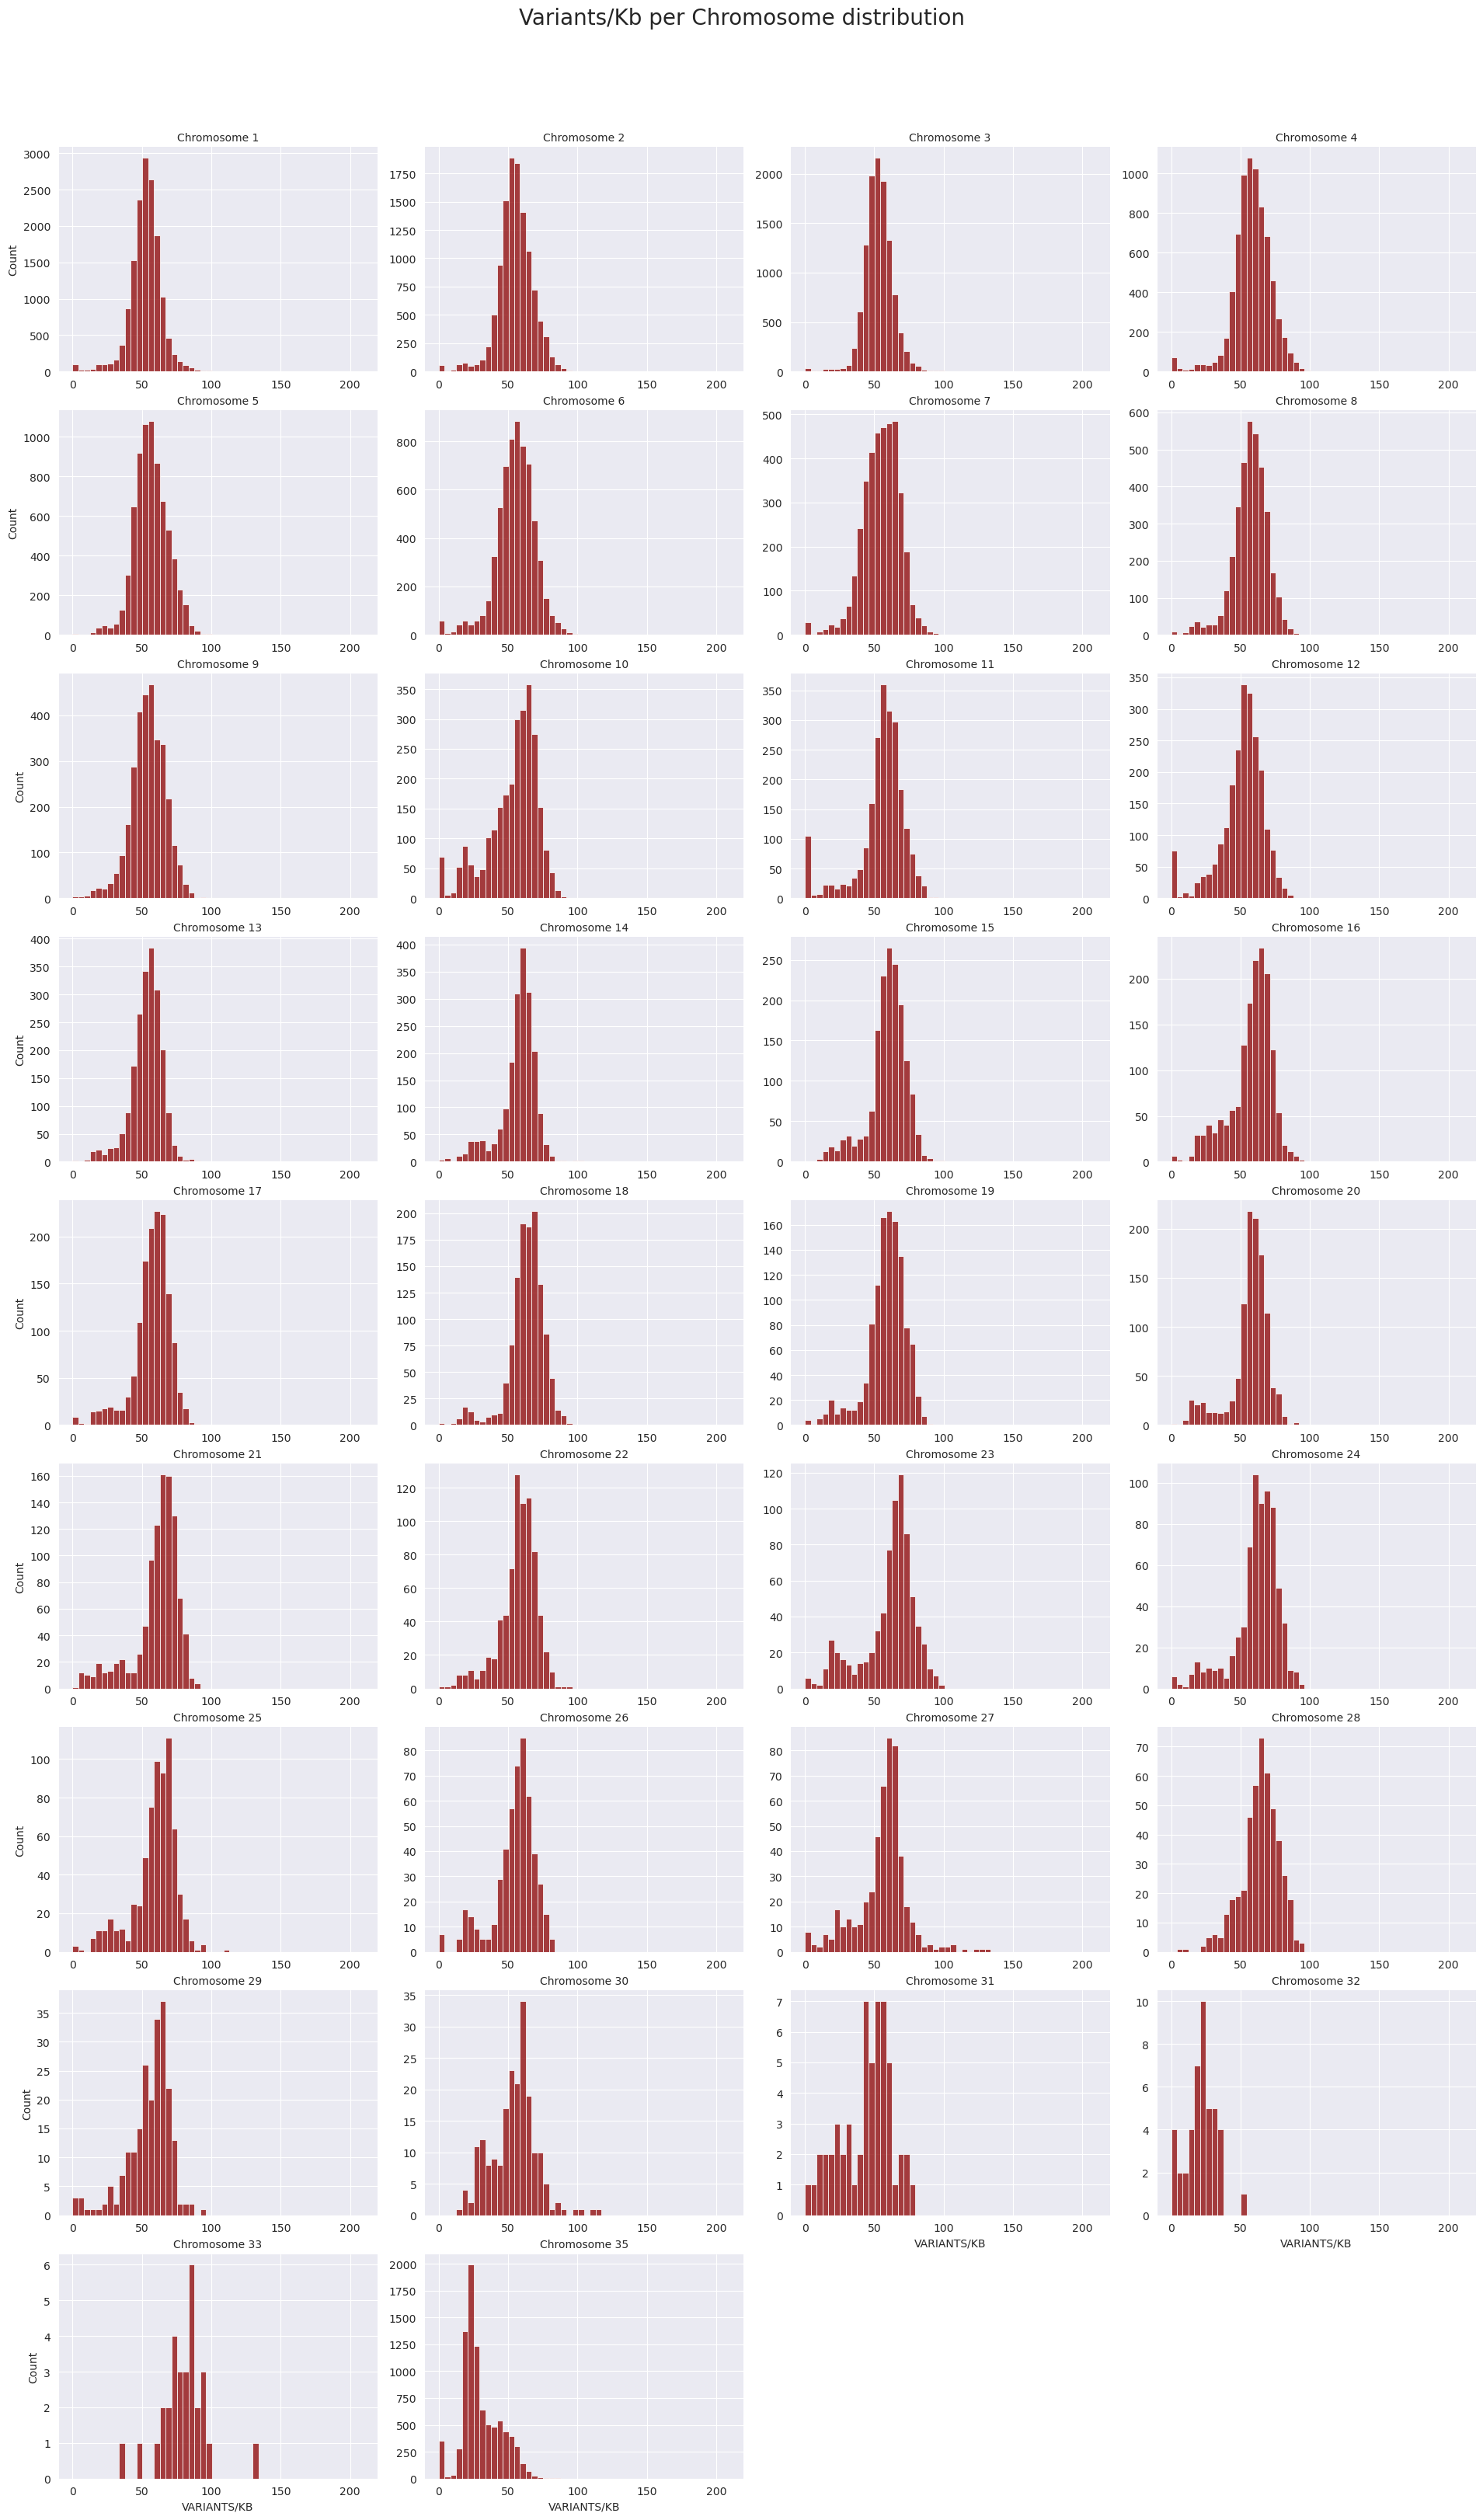

In [56]:
from textwrap import fill


seaborn.set_style("darkgrid")
seaborn.displot(data=vcf_stats, x="VARIANTS/KB", col="CHROM_NUM", 
    col_wrap=4, 
    kind="hist", 
    stat="count",
    color="darkred",# or "density", "probability"
    bins=50, 
    facet_kws={'sharex': False, 'sharey': False}, height=4, aspect=1.2).set_titles(col_template="Chromosome {col_name}", fontsize=14)
plt.subplots_adjust(top=0.85)
plt.suptitle("Variants/Kb per Chromosome distribution", fontsize=20, x=0.5, y=0.9, va='top')
plt.show()